# Defining imports

In [44]:
import cv2
import numpy as np
import sys
import math
# import os 
import glob
import matplotlib.pyplot as plt

# Making functions

In [64]:
def Cropping(image):
    hight, width, _ = image.shape
    cropped_img = image[round(hight*0):round(hight), round(width*0.05):round(width*0.97)]
    return cropped_img

def Gray_scale(image):
    image_copy = image.copy()
    img_gray = cv2.cvtColor(image_copy, cv2.COLOR_BGR2GRAY)
    return img_gray

def Analyse_chessboard(img_col, img_gray, chess_board, objp, criteria):
    obj_points = []
    img_points  = []
    img_col_copy = img_col.copy()
    #Find the chess board corners
    # If desired number of corners are found in the image then ret = true
    ret, corners = cv2.findChessboardCorners(img_gray, chess_board, cv2.CALIB_CB_ADAPTIVE_THRESH + cv2.CALIB_CB_FAST_CHECK + cv2.CALIB_CB_NORMALIZE_IMAGE)
     
    """
    If desired number of corner are detected, we refine the pixel coordinates and display them on the images of checker board
    """
    
    if ret == True:
        obj_points.append(objp)
        # refining pixel coordinates for given 2d points.
        corners2 = cv2.cornerSubPix(img_gray, corners, (11,11),(-1,-1), criteria)
         
        img_points.append(corners2)
 
        # Draw and display the corners
        img = cv2.drawChessboardCorners(img_col_copy, chess_board, corners2, ret)

    return img, obj_points, img_points

def Print_camera_callibrtion(ret, mtx, dist, rvecs, tvecs):
    print("Error in projection :") #RMS re-projection error. 
    print(ret, "\n") 
    print("Intrinsic matrix : \n") # Intrinsic parameters
    print(mtx)
    print("\n dist : \n") # [k1, k2, p1, p2, k3] k:radial distortion, p: tangential distortion
    print(dist)
    print("\n rvecs : \n") # Extrinsic Rodriguez
    print(rvecs)
    print("\n tvecs : \n") # Extrinsic Translation vector
    print(tvecs)

def Make_extrinsic(rvec, tvecs):
    rotation_matrix = np.zeros(shape=(3,3))
    cv2.Rodrigues(rvec, rotation_matrix)
    print("Rotation matrix: \n", rotation_matrix)

    rotation_mask = np.array([[1, 0], [0, 1], [0, 0]])
    chopped_rotation = np.matmul(rotation_matrix, rotation_mask)
    extrinsic_matrix = np.hstack((chopped_rotation,tvecs))
    print("\nExtrinsic matrix: \n", extrinsic_matrix)

    return extrinsic_matrix

def Make_homography_matrix(exetric, intrinsic):
    homography_matrix = np.matmul(intrinsic, exetric)
    print("\nPre homography matrix: \n", homography_matrix)

    homography_matrix = homography_matrix/homography_matrix[2][2]
    print("\nPost homography matrix: \n", homography_matrix)
    return homography_matrix

def inv_homography(homography):
    inv_homography_matrix=np.linalg.inv(homography)
    print("\n Inverse homography matrix: \n", inv_homography_matrix)
    return inv_homography_matrix

def Undestor_images(img_path, mtx, dist, rvecs, tvecs):
    img_to_undistort  = cv2.imread(img_path)

    # Draw axes from world center point
    cv2.drawFrameAxes(img_to_undistort, mtx, dist, rvecs[0], tvecs[0], length=1.5, thickness=3)
   
    # Refining the camera matrix:
    h,w = img_to_undistort.shape[:2]
    refined_camera_matrix, region_of_interest = cv2.getOptimalNewCameraMatrix(mtx, dist, (w,h), 1, (w,h))

    # Undistortion of the images
    img_distortion = cv2.undistort(img_to_undistort, mtx, dist, None, refined_camera_matrix)
    return img_distortion, refined_camera_matrix



# Init

In [47]:
# Each tile is 7x7 mm
chekcerboard_tile_size = 7

# Vertical and horizontal 
CHECKERBOARD = (4,4) 
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# Defining the world coordinates for 3D points
objp = np.zeros((1, CHECKERBOARD[0] * CHECKERBOARD[1], 3), np.float32)
objp[0,:,:2] = np.mgrid[0:CHECKERBOARD[0], 0:CHECKERBOARD[1]].T.reshape(-1, 2)
prev_img_shape = None

# Main code

Error in projection :
0.33339759383931666 

Intrinsic matrix : 

[[1.76373223e+03 0.00000000e+00 3.35661551e+02]
 [0.00000000e+00 1.76278882e+03 2.19615124e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]

 dist : 

[[-3.32233844e+00  4.69117480e+02 -3.85795273e-02  3.64036924e-02
  -4.02217028e+03]]

 rvecs : 

(array([[-0.01261611],
       [-0.03459531],
       [ 0.00259581]]),)

 tvecs : 

(array([[-1.32756919],
       [-1.18173251],
       [30.02686023]]),)
Rotation matrix: 
 [[ 0.99939828 -0.00237702 -0.03460382]
 [ 0.00281343  0.99991706  0.01256835]
 [ 0.03457108 -0.01265814  0.99932208]]

Extrinsic matrix: 
 [[ 9.99398282e-01 -2.37701687e-03 -1.32756919e+00]
 [ 2.81342545e-03  9.99917057e-01 -1.18173251e+00]
 [ 3.45710764e-02 -1.26581399e-02  3.00268602e+01]]

Pre homography matrix: 
 [[ 1.77427514e+03 -8.44127214e+00  7.73738590e+03]
 [ 1.25518062e+01  1.75986269e+03  4.51120778e+03]
 [ 3.45710764e-02 -1.26581399e-02  3.00268602e+01]]

Post homography matrix: 
 [[ 5.90895

(-0.5, 639.5, 479.5, -0.5)

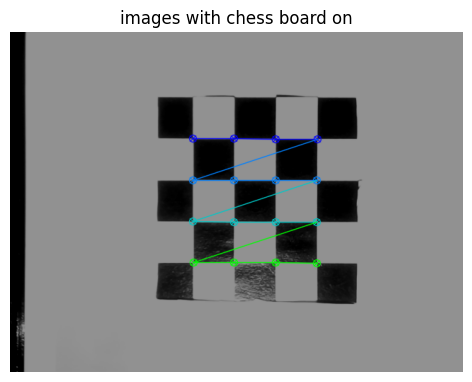

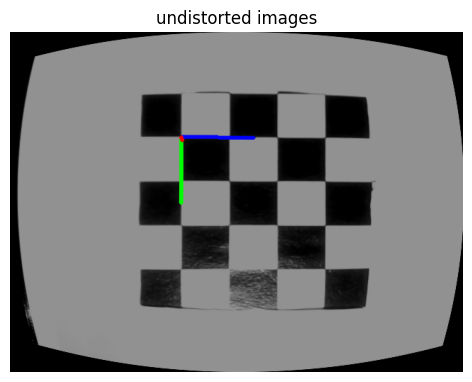

In [67]:
picture_path = "Images/ChessBoards/"
folder = "LimitedBoards2/"
file_name = "000001.bmp"
pic_name = picture_path + folder + file_name

img = cv2.imread(pic_name)
img_gr = Gray_scale(img)

img_sq, obj_points, img_points = Analyse_chessboard(img, img_gr, CHECKERBOARD, objp, criteria)

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(obj_points, img_points, img_gr.shape[::-1], None, None)
Print_camera_callibrtion(ret, mtx, dist, rvecs, tvecs)
ext_matrix = Make_extrinsic(rvecs[0], tvecs[0])
homo_matrix = Make_homography_matrix(ext_matrix, mtx)
inv_homo = inv_homography(homo_matrix)

undist_img, new_matrix = Undestor_images(pic_name, mtx, dist, rvecs, tvecs)

plt.figure(figsize=(30, 15))
plt.subplot(3,3,1)
plt.imshow(img_sq)
plt.title('images with chess board on')
plt.axis('off')

plt.figure(figsize=(30, 15))
plt.subplot(3,3,2)
plt.imshow(undist_img)
plt.title('undistorted images')
plt.axis('off')




In [69]:
print(undist_img.shape[:2])
print(img.shape[:2])

(480, 640)
(480, 640)
